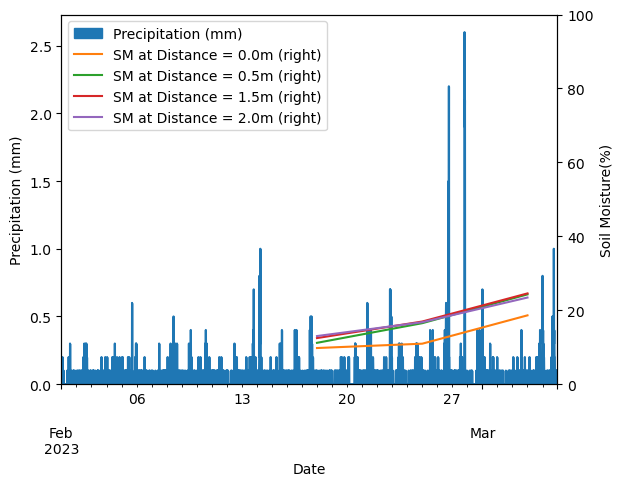

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt

precip_strt = pd.to_datetime('2/1/2023 0:00')
precip_end = pd.to_datetime('3/6/2023 0:00')

# read in data
sm_df = pd.read_csv('soil_moisture_digitized_data.csv')
lw_df = pd.read_csv('LW_15minSummary_2023_Preliminary.csv', header=19)

#Convert date from string to DateTime for consistent x-axis data type
sm_df['Date'] = pd.to_datetime(sm_df['Date'], format='%m/%d/%Y')
lw_df['DateTime'] = pd.to_datetime(lw_df['DateTime'], format='%m/%d/%Y %H:%M')

#Subset precip and get hourly precip from cumulative
precip_df = lw_df.loc[(lw_df['DateTime']>=precip_strt)&(lw_df['DateTime']<precip_end), ["DateTime", "Precipitation-mm"]]
precip_df["Precip-hrly-mm"] = precip_df["Precipitation-mm"].diff()
#Remove negative precips so area plot will work
precip_df['Precip-hrly-mm'] = precip_df['Precip-hrly-mm'].apply(lambda pr: 0 if pr < 0 else pr)
#Plot precip v time
ax = precip_df.plot(x="DateTime", y="Precip-hrly-mm", kind='area', label='Precipitation (mm)',
                   ylabel='Precipitation (mm)')

#Subset soil moisture df and find mean at each distance for each date
sm_sub_df = sm_df.loc[:, ['Date','Distance','Soil Moisture(%)']]
sm_mean_df = sm_sub_df.groupby(['Date', 'Distance']).mean()
sm_mean_df = sm_mean_df.reset_index()

#Plot SM v time for each distance (there probably a more elegant way, but this will work for now)
sm_mean_df.loc[sm_mean_df['Distance'] == 0.0, ['Date', 'Soil Moisture(%)']].plot(
    ax=ax, x='Date', y='Soil Moisture(%)', label='SM at Distance = 0.0m', secondary_y=True, 
    ylim=(0,100), ylabel='Soil Moisture(%)')
sm_mean_df.loc[sm_mean_df['Distance'] == 0.5, ['Date', 'Soil Moisture(%)']].plot(
    ax=ax, x='Date', y='Soil Moisture(%)', label='SM at Distance = 0.5m', secondary_y=True)
sm_mean_df.loc[sm_mean_df['Distance'] == 1.0, ['Date', 'Soil Moisture(%)']].plot(
    ax=ax, x='Date', y='Soil Moisture(%)', label='SM at Distance = 1.5m', secondary_y=True)
sm_mean_df.loc[sm_mean_df['Distance'] == 1.5, ['Date', 'Soil Moisture(%)']].plot(
    ax=ax, x='Date', y='Soil Moisture(%)', label='SM at Distance = 2.0m', secondary_y=True)

plt.show()